In [1]:
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt

FILE_PATH = "../shared_data_read_only/"
FILES = ("consumer_price_index.xlsx","Contacts.xlsx","Invoice and Opportunities.xlsx",
         "Items and Opportunities.xlsx","Non-Stock Items.xlsx","Opportunities.xlsx")

In [2]:
df_cpi = pd.read_excel(f"{FILE_PATH}{FILES[0]}",)
df_cpi =  df_cpi.set_index('Date')
df_cpi = df_cpi.sort_index()
df_cpi['consumer_price_index_diff'] = df_cpi['consumer_price_index'].pct_change().fillna(0) # differentiating -> stationnary
df_cpi.head()

,consumer_price_index,consumer_price_index_diff
Date,,
2019-01-01,103.01,0.000000
2019-02-01,103.06,0.000485
2019-03-01,103.89,0.008054
2019-04-01,104.22,0.003176
2019-05-01,104.33,0.001055


In [3]:
df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2019-01-01 to 2023-08-01
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   consumer_price_index       56 non-null     float64
 1   consumer_price_index_diff  56 non-null     float64
dtypes: float64(2)
memory usage: 1.3 KB


In [4]:
df_cpi.describe()

,consumer_price_index,consumer_price_index_diff
count,56.000000,56.000000
mean,108.310536,0.002571
std,4.748734,0.003976
min,103.010000,-0.005645
25%,104.575000,0.000000
50%,106.030000,0.002028
75%,112.597500,0.004430
max,118.890000,0.014228


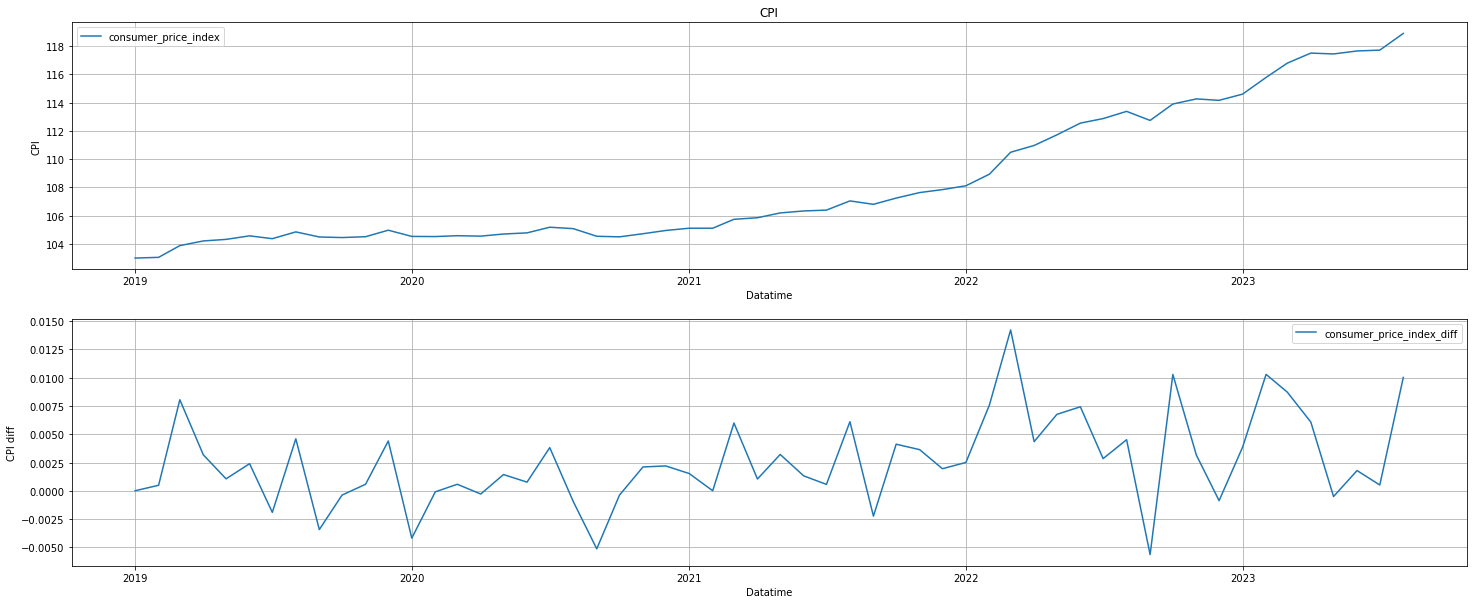

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(25, 10))

ax[0].plot(df_cpi.index,df_cpi['consumer_price_index'],label="consumer_price_index")
ax[0].set_title(f"CPI")
ax[0].yaxis.set_label_text("CPI")
ax[0].xaxis.set_label_text("Datatime")
# ax[0].set_yscale("log")
ax[0].legend()
ax[0].grid()
ax[1].plot(df_cpi.index,df_cpi['consumer_price_index_diff'],label="consumer_price_index_diff")

ax[1].yaxis.set_label_text("CPI diff")
ax[1].xaxis.set_label_text("Datatime")
ax[1].legend()
ax[1].grid()


In [6]:
file_no = 2 # Invoice
df_invoice = pd.read_excel(f"{FILE_PATH}{FILES[file_no]}")
print(f"File : {FILES[file_no]}")

df_invoice_agg = (df_invoice.groupby(by=["Date"])
              .agg({"Opportunity ID":"count","Reference Nbr.":"count","Amount":'sum'})
              .resample("MS")
              .agg({"Opportunity ID":"sum","Reference Nbr.":"sum","Amount":'sum'}))

df_invoice_agg.head()

File : Invoice and Opportunities.xlsx


,Opportunity ID,Reference Nbr.,Amount
Date,,,
2020-01-01,1,1,350000.00
2020-02-01,0,0,0.00
2020-03-01,1,1,3000.00
2020-04-01,1,1,209.08
2020-05-01,1,1,436988.09


In [7]:
df_invoice

,Type,Reference Nbr.,Customer,Amount,Date,Opportunity ID
0,Invoice,FC0004608,C06507,5000.00,2023-10-10,4504
1,Invoice,FC0004607,C01388,241253.00,2023-10-09,1863
2,Invoice,FC0004605,C19104,83954.00,2023-10-06,5708
3,Invoice,FC0004600,C10528,3000.00,2023-06-23,5617
4,Invoice,FC0004598,C01196,54531.00,2023-10-09,5829
...,...,...,...,...,...,...
3233,Invoice,FC0000008,C00087,5000.00,2021-03-11,1410
3234,Invoice,FC0000007,C00589,3000.00,2020-03-29,1056
3235,Invoice,FC0000005,C00644,4504.95,2021-03-15,1499
3236,Invoice,FC0000004,C00644,455.37,2021-03-15,1495


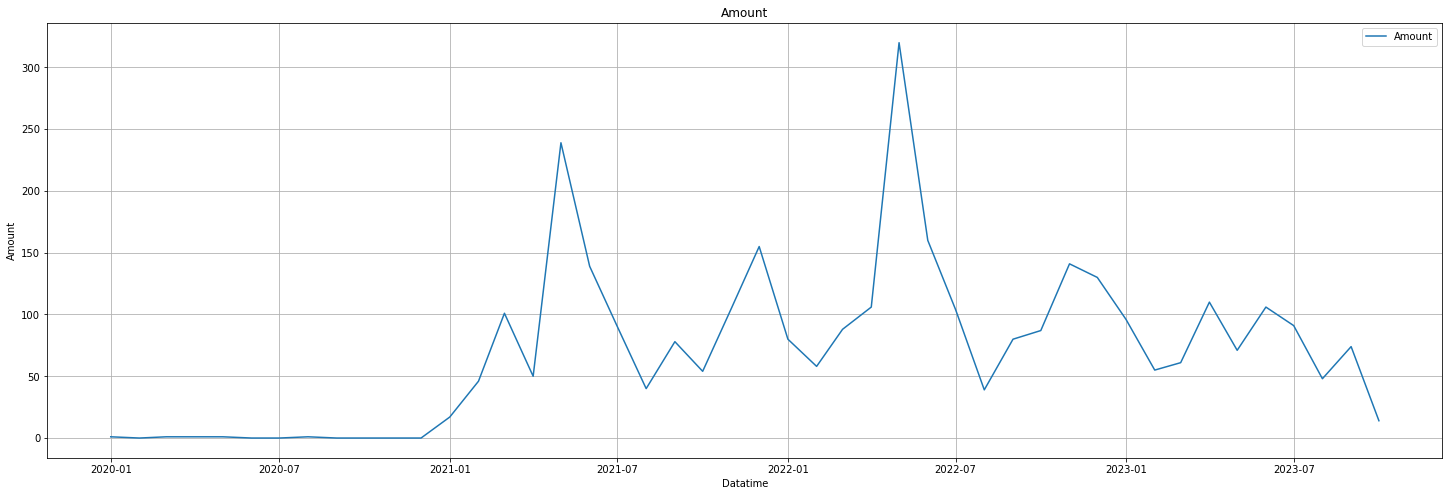

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(25, 8))

ax.plot(df_invoice_agg.index,df_invoice_agg['Reference Nbr.'],label='Amount')
ax.set_title(f"Amount")
ax.yaxis.set_label_text("Amount")
ax.xaxis.set_label_text("Datatime")
ax.legend()
ax.grid()


In [9]:
df_merged_cpi_invoice = pd.merge(df_invoice_agg, df_cpi, left_index=True, right_index=True).loc['2021-01-01':]
df_merged_cpi_invoice.head()

,Opportunity ID,Reference Nbr.,Amount,consumer_price_index,consumer_price_index_diff
Date,,,,,
2021-01-01,17,17,283466.91,105.12,0.001524
2021-02-01,46,46,1236812.39,105.12,0.000000
2021-03-01,101,101,2923682.43,105.75,0.005993
2021-04-01,50,50,1009514.52,105.86,0.001040
2021-05-01,239,239,2053851.04,106.20,0.003212


In [10]:
scaler = MinMaxScaler()
consumer_price_index_diff_scaled = scaler.fit_transform(df_merged_cpi_invoice.consumer_price_index_diff.to_numpy().reshape(-1, 1))

model = GaussianMixture(n_components=2, covariance_type="full", random_state=42,max_iter=1000) # 2 Market Regimes
model.fit(consumer_price_index_diff_scaled)
consumer_price_index_diff_predicted = model.predict(consumer_price_index_diff_scaled)
df_merged_cpi_invoice['GM_regime'] = consumer_price_index_diff_predicted

df_merged_cpi_invoice.head()

,Opportunity ID,Reference Nbr.,Amount,consumer_price_index,consumer_price_index_diff,GM_regime
Date,,,,,,
2021-01-01,17,17,283466.91,105.12,0.001524,0
2021-02-01,46,46,1236812.39,105.12,0.000000,0
2021-03-01,101,101,2923682.43,105.75,0.005993,0
2021-04-01,50,50,1009514.52,105.86,0.001040,0
2021-05-01,239,239,2053851.04,106.20,0.003212,0


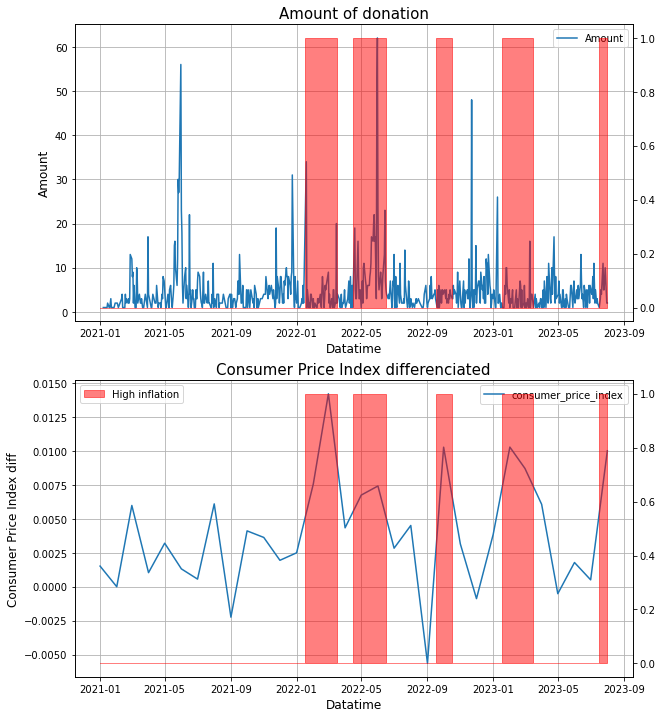

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
df_invoice_grouped_day = df_invoice.groupby(by=["Date"]).agg({"Opportunity ID":"count","Amount":'sum',"Reference Nbr.":"count"}).loc['2021-01-01':df_merged_cpi_invoice.index[-1]]
ax[0].plot(df_invoice_grouped_day.index,df_invoice_grouped_day["Reference Nbr."],label='Amount')
# ax[0].plot(df_merged_cpi_invoice.index,df_merged_cpi_invoice['Opportunity ID'],label='Amount')
ax_l = ax[0].twinx()

ax_l.fill_between(df_merged_cpi_invoice.index,df_merged_cpi_invoice.GM_regime,color='red',alpha=0.5, step='mid')
ax[0].set_title(f"Amount of donation",fontsize=15)
ax[0].yaxis.set_label_text("Amount",fontsize=12)
ax[0].xaxis.set_label_text("Datatime",fontsize=12)
ax[0].legend()
ax[0].grid()

ax[1].plot(df_merged_cpi_invoice.index,df_merged_cpi_invoice.consumer_price_index_diff,label='consumer_price_index')
ax_l = ax[1].twinx()
ax_l.fill_between(df_merged_cpi_invoice.index,df_merged_cpi_invoice.GM_regime,color='red',alpha=0.5, step='mid',label='High inflation')
ax[1].set_title(f"Consumer Price Index differenciated",fontsize=15)
ax[1].yaxis.set_label_text("Consumer Price Index diff",fontsize=12)
ax[1].xaxis.set_label_text("Datatime",fontsize=12)
ax[1].legend(['consumer_price_index'])
ax_l.legend(loc="upper left")
ax[1].grid()


In [12]:
df_invoice_grouped_day

,Opportunity ID,Amount,Reference Nbr.
Date,,,
2021-01-07,1,20000.00,1
2021-01-11,1,10000.00,1
2021-01-12,1,5000.00,1
2021-01-13,1,5000.00,1
2021-01-14,1,5000.00,1
...,...,...,...
2023-07-25,5,61799.00,5
2023-07-26,5,639696.87,5
2023-07-28,10,89000.00,10
